In [99]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl

## Set params

In [73]:
Lambda = 1
T = 6
a = 1
b = 1

#for testing
np.random.seed(42)
rng_master = npr.default_rng(42)
rng1 = npr.default_rng(rng_master.bit_generator.seed_seq)
rng2 = npr.default_rng(rng_master.bit_generator.seed_seq)

In [74]:
from scipy.sparse import diags

def BuildD(T):
    k = [np.ones(T),-2*np.ones(T-1),np.ones(T-2)]
    offset = [0,-1,-2]
    D = diags(k,offset).toarray()/4
    return D
    
#U,Delta,V
def BuildUVDelta(D):
    U, Delta, Vt = npl.svd(D, full_matrices=False)
    return U,Delta,Vt
#A
def BuildA(Delta,Vt):
    A = np.diag(Delta) @ Vt
    return A
#sh
def Buildsh(T,a,b):
    sh = np.zeros(T)
    sh[0] = (a-2*b)/4
    sh[1] = b/4
    return sh

def ComputeArgmax(T, Lambda, Y, a, b):
    D = BuildD(T)
    U, Delta, Vt = BuildUVDelta(D)
    A = BuildA(Delta, Vt)
    sh = Buildsh(T, a, b)
    
    u=U@Y+sh
    x_tilde=np.sign(u)*np.maximum(np.abs(u)-Lambda,np.zeros(T))-sh
    x=npl.solve(D,x_tilde)
    return x,x_tilde

def LogDistributionPi(x, Y, A, D, sh, Lambda):
    return (-npl.norm(Y - A@x)**2)/2-Lambda*npl.norm(D@x + sh,ord=1)

def LogDistributionPi_tilde(x_tilde, Y, U, sh, Lambda):
    return (-npl.norm(U@Y - x_tilde)**2)/2-Lambda*npl.norm(x_tilde + sh,ord=1)

def Computation_Y_circ_test(T, a, b, rng):

    D = BuildD(T)
    U, Delta, Vt = BuildUVDelta(D)
    A = BuildA(Delta, Vt)
    coeff_dir = 2.7/T
    ord_ori = 0.1
    
    sh = Buildsh(T,a,b)
    x_true = np.zeros(T)

    for i in range(int(T/3)):
        x_true[i] = coeff_dir * i + ord_ori

    coeff_dir = -3/T
    ord_ori = 2
    
    for i in range(int(T/3), T):
        x_true[i] = coeff_dir * (i - int(T/3)) + 2

    x_true = 10*x_true
    Y = rng.multivariate_normal(A @ x_true, np.identity(T))
    
    return Y

def LogDistributionPi_Tab(x_tab, Y, A, D, sh, Lambda):
    l_tab = np.empty(np.shape(x_tab)[0])
    for i,xi in enumerate(x_tab):
        l_tab[i] = LogDistributionPi(xi,Y,A,D,sh,Lambda)
    return l_tab

In [75]:
def MetropolisHastings_Source(T, Lambda, Y, a,b,niter=1e5):

    plt.figure()
    x,*_ = ComputeArgmax(T,Lambda, Y,a,b)
    
    
    D = BuildD(T)
    gamma = 0.001
    accept_final = 0.24
    U, Delta, Vt = BuildUVDelta(D)
    A = BuildA(Delta, Vt)
    sh = Buildsh(T, a, b)
    theta = np.linalg.solve(D, rng1.uniform(-1, 1, T))
    end_burn_in=None

    # Covariance matrix C
    C = np.identity(T)
    
    # Burn-in aux variables
    burn_in = True
    wait_conv = False
    acceptance_cnt = 0
    rd = rng1.uniform(0, 1, int(niter+1))
    
    theta_tab = np.empty((int(niter+1), T))
    theta_tab[0,:] = theta
    
    cnt = 0
    converge=0

    # for plotting

    cpt = 0
    gammas = []
    accepts = []

    # burn-in loop
    for i in range(int(niter/2)):

        mu = theta
        candidate = rng1.multivariate_normal(mu, gamma*C)
        log_alpha = LogDistributionPi(candidate, Y, A, D, sh, Lambda) - LogDistributionPi(theta, Y, A, D, sh, Lambda)
            
        if log_alpha >=0 :
            theta = candidate
            acceptance_cnt += 1
        else:
            if rd[i] <= np.exp(log_alpha): 
                theta = candidate
                acceptance_cnt += 1
                
        theta_tab[i+1,:]=theta
        
        # burn-in
        if ((i+1) % 1000) == 0:
            plt.plot(theta, "r", alpha = i/niter)
            accept_rate = acceptance_cnt / 1000
            gamma += (accept_rate - accept_final) * gamma
            gammas.append(gamma)
            accepts.append(accept_rate)
            cpt += 1
            acceptance_cnt = 0
            if burn_in:
                burn_in = abs(accept_rate - accept_final) > 1e-2
                wait_conv = not burn_in
            elif wait_conv:
                converge += 1
                wait_conv = converge < 1e-4 * niter
                if not(wait_conv):
                    end_burn_in=i
                    break
    
    accepts = np.array(accepts)
    gammas  = np.array(gammas)

    if(wait_conv):
        end_burn_in=int(niter/2)
    
    print("End of the burn-in")

    ## convergence loop
    for i in range(end_burn_in,int(niter)):
        mu = theta
        candidate = rng1.multivariate_normal(mu, gamma*C)
        log_alpha = LogDistributionPi(candidate, Y, A, D, sh, Lambda) - LogDistributionPi(theta, Y, A, D, sh, Lambda)
        if log_alpha >=0 :
            theta = candidate
        else:
            if rd[i] <= np.exp(log_alpha):
                theta = candidate
            
        cnt += 1
        theta_tab[i+1,:] = theta

        if((i+1)%1000 == 0):
            plt.plot(theta, "r", alpha = i/niter)

    plt.plot(x, "b")
    plt.ylim(np.min(x), np.max(x))
    plt.show()

        
    return theta_tab, accepts, gammas, theta_tab.mean(axis=0), end_burn_in

In [76]:
def MetropolisHastings_Image(T, Lambda, Y, a,b,niter=1e5):

    plt.figure()
    x,*_ = ComputeArgmax(T,Lambda, Y,a,b)
    
    
    D = BuildD(T)
    gamma = 0.001
    accept_final = 0.24
    U, Delta, Vt = BuildUVDelta(D)
    A = BuildA(Delta, Vt)
    sh = Buildsh(T, a, b)
    theta_tilde = npl.solve(D, rng2.uniform(-1, 1, T))
    theta_tilde = D@theta_tilde 
    end_burn_in=None

    # Covariance matrix C
    D_1 = npl.solve(D, np.identity(T))
    C = D_1@D_1.T
    
    # Burn-in aux variables
    burn_in = True
    wait_conv = False
    acceptance_cnt = 0
    rd = rng2.uniform(0, 1, int(niter+1))
    
    theta_tilde_tab = np.empty((int(niter+1), T))
    theta_tilde_tab[0,:] = theta_tilde
    
    cnt = 0
    converge=0

    # for plotting

    cpt = 0
    gammas = []
    accepts = []
    

    # burn-in loop
    for i in range(int(niter/2)):

        mu = theta_tilde
        candidate = rng2.multivariate_normal(mu, gamma*C)
        log_alpha = LogDistributionPi_tilde(candidate, Y, U, sh, Lambda) - LogDistributionPi_tilde(theta_tilde, Y, U, sh, Lambda)
            
        if log_alpha >=0 :
            theta_tilde = candidate
            acceptance_cnt += 1
        else:
            if rd[i] <= np.exp(log_alpha): 
                theta_tilde = candidate
                acceptance_cnt += 1
                
        theta_tilde_tab[i+1,:] = theta_tilde
        
        # burn-in
        if ((i+1) % 1000) == 0:
            plt.plot(D_1@theta_tilde, "r", alpha = i/niter)
            accept_rate = acceptance_cnt / 1000
            gamma += (accept_rate - accept_final) * gamma
            gammas.append(gamma)
            accepts.append(accept_rate)
            cpt += 1
            acceptance_cnt = 0
            if burn_in:
                burn_in = abs(accept_rate - accept_final) > 1e-2
                wait_conv = not burn_in
            elif wait_conv:
                converge += 1
                wait_conv = converge < 1e-4 * niter
                if not(wait_conv):
                    end_burn_in=i
                    break
    
    accepts = np.array(accepts)
    gammas  = np.array(gammas)

    if(wait_conv):
        end_burn_in=int(niter/2)
    
    print("End of the burn-in")

    ## convergence loop
    for i in range(end_burn_in,int(niter)):
        mu = theta_tilde
        candidate = rng2.multivariate_normal(mu, gamma*C)
        log_alpha = LogDistributionPi_tilde(candidate, Y, U, sh, Lambda) - LogDistributionPi_tilde(theta_tilde, Y, U, sh, Lambda)
        if log_alpha >=0 :
            theta_tilde = candidate
        else:
            if rd[i] <= np.exp(log_alpha): # probability alpha of success
                theta_tilde = candidate
            
        cnt += 1
        theta_tilde_tab[i+1,:] = theta_tilde

        if((i+1)%1000 == 0):
            plt.plot(D_1@theta_tilde, "r", alpha = i/niter)

    plt.plot(x, "b")
    plt.ylim(np.min(x), np.max(x))
    plt.show()

    theta_tab = D_1@theta_tilde_tab.T
    theta_tab = theta_tab.T
    return theta_tab, accepts, gammas, (theta_tab).mean(axis=0), end_burn_in

Now we will recreate the 'MetropolisHastings_Image' algorithm, but make it simulate thetas and not theta_tildes.

In [77]:
def MetropolisHastings_Image_2(T, Lambda, Y, a,b,niter=1e5):

    plt.figure()
    x,*_ = ComputeArgmax(T,Lambda, Y,a,b)
    
    
    D = BuildD(T)
    gamma = 0.001
    accept_final = 0.24
    U, Delta, Vt = BuildUVDelta(D)
    A = BuildA(Delta, Vt)
    sh = Buildsh(T, a, b)
    theta = np.linalg.solve(D, rng1.uniform(-1, 1, T))
    end_burn_in=None

    # Covariance matrix C
    D_1 = npl.solve(D, np.identity(T))
    C = D_1@D_1.T
    
    # Burn-in aux variables
    burn_in = True
    wait_conv = False
    acceptance_cnt = 0
    rd = rng1.uniform(0, 1, int(niter+1))
    
    theta_tab = np.empty((int(niter+1), T))
    theta_tab[0,:] = theta
    
    cnt = 0
    converge=0

    # for plotting

    cpt = 0
    gammas = []
    accepts = []

    # burn-in loop
    for i in range(int(niter/2)):

        mu = theta
        candidate = rng1.multivariate_normal(mu, gamma*C)
        log_alpha = LogDistributionPi(candidate, Y, A, D, sh, Lambda) - LogDistributionPi(theta, Y, A, D, sh, Lambda)
            
        if log_alpha >=0 :
            theta = candidate
            acceptance_cnt += 1
        else:
            if rd[i] <= np.exp(log_alpha): 
                theta = candidate
                acceptance_cnt += 1
                
        theta_tab[i+1,:]=theta
        
        # burn-in
        if ((i+1) % 1000) == 0:
            plt.plot(theta, "r", alpha = i/niter)
            accept_rate = acceptance_cnt / 1000
            gamma += (accept_rate - accept_final) * gamma
            gammas.append(gamma)
            accepts.append(accept_rate)
            cpt += 1
            acceptance_cnt = 0
            if burn_in:
                burn_in = abs(accept_rate - accept_final) > 1e-2
                wait_conv = not burn_in
            elif wait_conv:
                converge += 1
                wait_conv = converge < 1e-4 * niter
                if not(wait_conv):
                    end_burn_in=i
                    break
    
    accepts = np.array(accepts)
    gammas  = np.array(gammas)

    if(wait_conv):
        end_burn_in=int(niter/2)
    
    print("End of the burn-in")

    ## convergence loop
    for i in range(end_burn_in,int(niter)):
        mu = theta
        candidate = rng1.multivariate_normal(mu, gamma*C)
        log_alpha = LogDistributionPi(candidate, Y, A, D, sh, Lambda) - LogDistributionPi(theta, Y, A, D, sh, Lambda)
        if log_alpha >=0 :
            theta = candidate
        else:
            if rd[i] <= np.exp(log_alpha):
                theta = candidate
            
        cnt += 1
        theta_tab[i+1,:] = theta

        if((i+1)%1000 == 0):
            plt.plot(theta, "r", alpha = i/niter)

    plt.plot(x, "b")
    plt.ylim(np.min(x), np.max(x))
    plt.show()

        
    return theta_tab, accepts, gammas, theta_tab.mean(axis=0), end_burn_in

In [78]:
Y_1 = Computation_Y_circ_test(T, a, b, rng1)
Y_2 = Computation_Y_circ_test(T, a, b, rng2)
print(np.allclose(Y_1, Y_2))

True


End of the burn-in


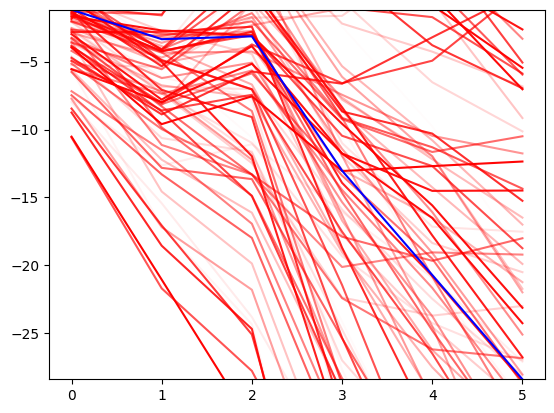

End of the burn-in


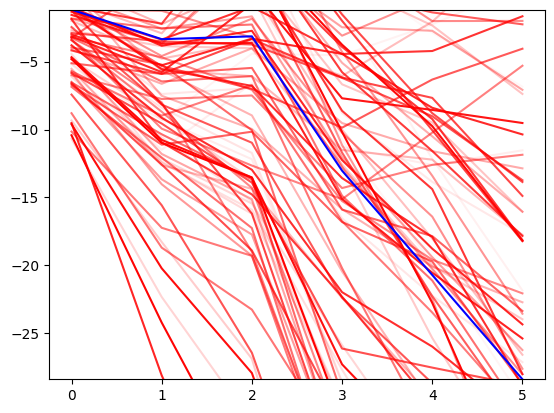

In [79]:
sim_image2, accepts_image2, gammas_image2, mean_image2, *_ = MetropolisHastings_Image_2(T, Lambda, Y_1, a, b)
sim_image,  accepts_image,  gammas_image,  mean_image,  *_ = MetropolisHastings_Image  (T, Lambda, Y_2, a, b)

In [80]:
print(mean_image)
print(mean_image2)

[ -2.78304187  -5.57686468  -5.37240057 -14.86797771 -20.91445985
 -27.16693707]
[ -2.34372619  -5.12573377  -4.56029529 -14.08126279 -20.33678099
 -26.73156757]


In [81]:
print(accepts_image.mean())
print(accepts_image2.mean())

0.28103333333333336
0.4682285714285715


In [82]:
print(gammas_image.mean())
print(gammas_image2.mean())

0.0026228332595061104
0.3763106524609428


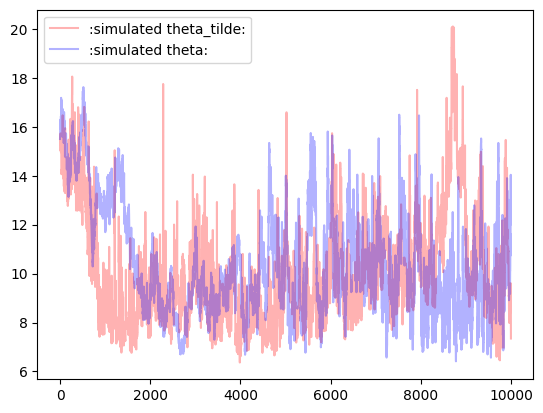

In [83]:
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)

plt.plot(-LogDistributionPi_Tab(sim_image[:10000],  Y_1, A, D, sh, Lambda), alpha=0.3, color="red",  label=":simulated theta_tilde:")
plt.plot(-LogDistributionPi_Tab(sim_image2[:10000], Y_2, A, D, sh, Lambda), alpha=0.3, color="blue", label=":simulated theta:")
plt.legend()
plt.show()

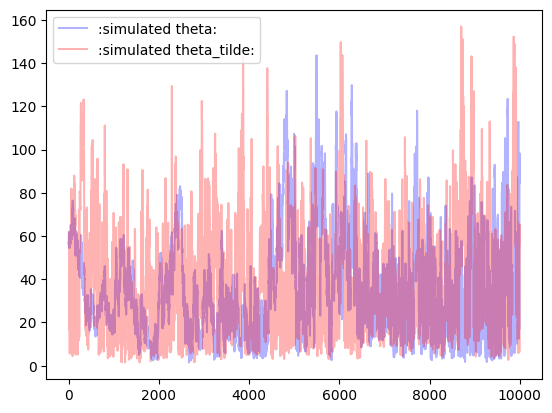

In [84]:
argmax,*_ = ComputeArgmax(T, Lambda, Y_1, a, b)

plt.plot(npl.norm(sim_image2[:10000]-argmax,axis=1), alpha=0.3, color="blue", label=":simulated theta:")
plt.plot(npl.norm(sim_image[:10000]-argmax,axis=1),  alpha=0.3, color="red",  label=":simulated theta_tilde:")
plt.legend()
plt.show()

In [86]:
print(-LogDistributionPi(sim_image[-1], Y_1, A, D, sh, Lambda))
print(-LogDistributionPi_tilde(D@sim_image[-1], Y_1, U, sh, Lambda))

8.135159684477534
8.135159684477564


I believe it to be better to compute theta_tildes when doing simulations in the image space. 